In [3]:
%matplotlib inline
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
current_dir = os.getcwd()
sess = tf.InteractiveSession()

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial, name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial, name)

def conv2d(X, W):
    return tf.nn.conv2d(X, W, strides = [1, 1, 1, 1], padding = 'SAME')

def max_pool_2x2(X):
    return tf.nn.max_pool(X, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

def add_layer(X, W, B):
    h_conv = tf.nn.relu(conv2d(X, W) + B)
    return max_pool_2x2(h_conv)

x = tf.placeholder(tf.float32, shape = [None, 784])
y_ = tf.placeholder(tf.float32, shape = [None, 10])
x_image = tf.reshape(x, [-1, 28, 28, 1])

layer1 = add_layer(x_image, weight_variable([5, 5, 1, 32], "w_conv1"), bias_variable([32], "b_conv1"))

layer2 = tf.nn.relu(conv2d(layer1, weight_variable([5, 5, 32, 48], "w_conv2")) + bias_variable([48], "b_conv2"))

layer3 = add_layer(layer2, weight_variable([5, 5, 48, 64], "w_conv3"), bias_variable([64], "b_conv3"))

W_fc1 = weight_variable([7 * 7 * 64, 1024], "w_fc1")
b_fc1 = bias_variable([1024], "b_fc1")
h_pool2_flat = tf.reshape(layer3, [-1, 7 * 7 * 64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
W_fc2 = weight_variable([1024, 10], "w_fc2")
b_fc2 = bias_variable([10], "b_fc2")
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#saver.restore(sess, os.path.join(current_dir, "model/mnist_cnn_3_layer/model.ckpt"))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.12
step 100, training accuracy 0.88
step 200, training accuracy 0.8
step 300, training accuracy 0.9
step 400, training accuracy 0.94
step 500, training accuracy 0.96
step 600, training accuracy 0.94
step 700, training accuracy 0.98
step 800, training accuracy 0.98
step 900, training accuracy 0.92
step 1000, training accuracy 0.98
step 1100, training accuracy 0.92
step 1200, training accuracy 0.94
step 1300, training accuracy 1
step 1400, training accuracy 0.96
step 1500, training accuracy 0.98
step 1600, training accuracy 0.98
step 1700, training accuracy 0.98
step 1800, training accuracy 0.96
step 1900, training accuracy 0.98
step 2000, training accuracy 0.96
step 2100, training accuracy 0.96
step 2200, training accuracy 0.98
step 2300, training accuracy 0.98
step 2400, training accuracy 1
step 2500, training accuracy 1
step 2600, training accuracy 0.96
step 2700, training accuracy 1
step 2800, training accuracy 1
step 2900, training accuracy 0.98
step 3000

/home/nbuser/anaconda2_501/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


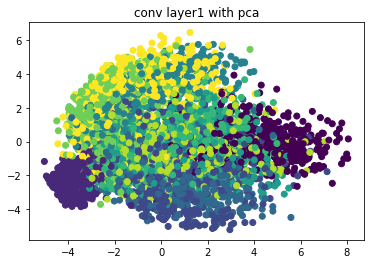

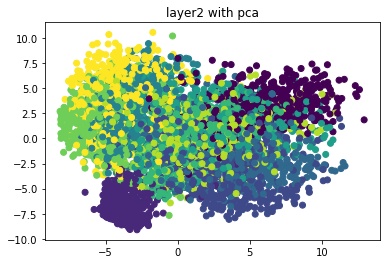

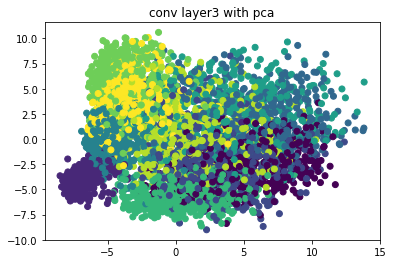

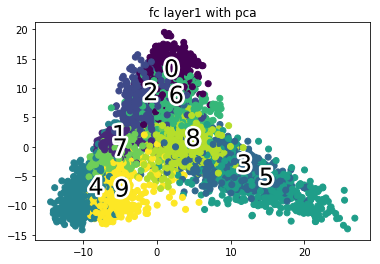

In [5]:
def pca(X, n_components):
    pca = PCA(n_components = n_components)
    pca.fit(X)
    return pca.transform(X)

def tsne(X, n_components):
    model = TSNE(n_components=2, perplexity=40)
    return model.fit_transform(X)

def plot_scatter(x, labels, title, txt = False):
    plt.title(title)
    ax = plt.subplot()
    ax.scatter(x[:,0], x[:,1], c = labels)
    txts = []
    if txt:
        for i in range(10):
            xtext, ytext = np.median(x[labels == i, :], axis=0)
            txt = ax.text(xtext, ytext, str(i), fontsize=24)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])
            txts.append(txt)
    plt.show()

test_size = 5000
test_data = mnist.test.images[0:test_size, :]
test_label = mnist.test.labels[0:test_size, :]
test_label_index = np.argmax(test_label, axis = 1)

layer1_reshape = tf.reshape(layer1[:, :, :, :], [-1, 14 * 14 * 32])
test_layer1_pca = pca(layer1_reshape.eval(feed_dict = {x: test_data}), 2)
plot_scatter(test_layer1_pca, test_label_index, "conv layer1 with pca")

layer2_reshape = tf.reshape(layer2[:, :, :, :], [-1, 14 * 14 * 48])
test_layer2_pca = pca(layer2_reshape.eval(feed_dict = {x: test_data}), 2)
plot_scatter(test_layer2_pca, test_label_index, "layer2 with pca")

layer3_reshape = tf.reshape(layer3[:, :, :, :], [-1, 7 * 7 * 64])
test_layer3_pca = pca(layer3_reshape.eval(feed_dict = {x: test_data}), 2)
plot_scatter(test_layer3_pca, test_label_index, "conv layer3 with pca")

fc1_pca = pca(h_fc1.eval(feed_dict = {x: test_data}), 2)
plot_scatter(fc1_pca, test_label_index, "fc layer1 with pca", txt = True)

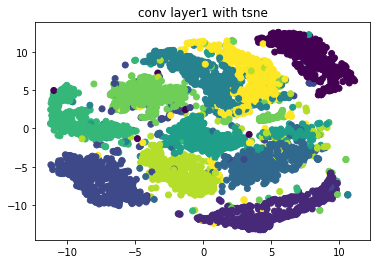

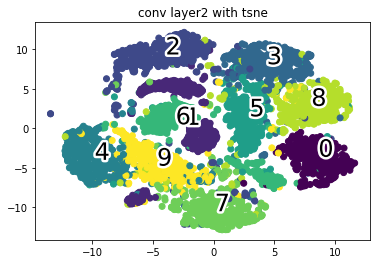

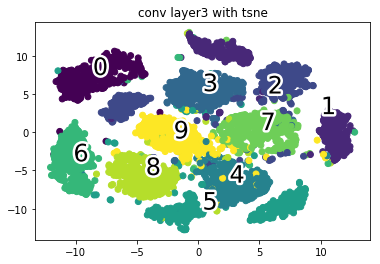

In [ ]:
layer1_reshape = tf.reshape(layer1[:, :, :, :], [-1, 14 * 14 * 32])
layer1_pca = pca(layer1_reshape.eval(feed_dict ={ x: test_data}), 50)
layer1_tsne = tsne(layer1_pca, 2)
plot_scatter(layer1_tsne, test_label_index, "conv layer1 with tsne")

layer2_reshape = tf.reshape(layer2[:, :, :, :], [-1, 14 * 14 * 48])
layer2_pca = pca(layer2_reshape.eval(feed_dict ={ x: test_data}), 50)
layer2_tsne = tsne(layer2_pca, 2)
plot_scatter(layer2_tsne, test_label_index, "conv layer2 with tsne", txt = True)

layer3_reshape = tf.reshape(layer3[:, :, :, :], [-1, 7 * 7 * 64])
layer3_pca = pca(layer3_reshape.eval(feed_dict = {x: test_data}), 50)
layer3_tsne = tsne(layer3_pca, 2)
plot_scatter(layer3_tsne, test_label_index, "conv layer3 with tsne", txt = True)

fc1_pca = pca(h_fc1.eval(feed_dict = {x: test_data}), 50)
fc1_tsne = tsne(fc1_pca, 2)
plot_scatter(fc1_tsne, test_label_index, "fc layer1 with tsne", txt = True)

fc2_tsne = tsne(y_conv.eval(feed_dict = {x: test_data, keep_prob: 1.0}), 2)
plot_scatter(fc2_tsne, test_label_index, "fc layer2 with tsne", txt = True)